In [12]:
import re
from typing import List, Tuple


def match_misalignment_label_to_token(
    misalignment_label,
    prompt,
):
  """Matches the misalignment label to the token.

  Args:
    misalignment_label: The misalignment label from RichHF-18K dataset.
    prompt: The prompt from the Pick-a-pic dataset.

  Returns:
    A list of pairs of token and misalignment label.
  """
  delimiters = ',.?!":; '
  pattern = '|'.join(map(re.escape, delimiters))
  # Split by punctuation or space and remove empty tokens.
  tokens = re.split(pattern, prompt)
  tokens = [t for t in tokens if t]

  misalignment_label = misalignment_label.split(' ')
  misalignment_label = [int(l) for l in misalignment_label]
  assert len(tokens) == len(misalignment_label)
  return list(zip(tokens, misalignment_label))


if __name__ == '__main__':
  text = 'RichHF-18K: a dataset for rich human feedback on generative images.'
  label = '0 1 0 0 0 1 0 0 1 0'
  pairs = match_misalignment_label_to_token(label, text)
  print(pairs)

[('RichHF-18K', 0), ('a', 1), ('dataset', 0), ('for', 0), ('rich', 0), ('human', 1), ('feedback', 0), ('on', 0), ('generative', 1), ('images', 0)]


In [43]:
from collections.abc import Sequence

from absl import app
import tensorflow as tf
def get_record_by_filename(filename):
  """Parses a TFRecord file and returns the record with the specified filename."""
  output = []
  raw_dataset = tf.data.TFRecordDataset(filename)
  for idx, raw_record in enumerate(raw_dataset):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feat_map = example.features.feature

    # Original filename which can be mapped to images in pick-a-pic dataset.
    record_filename = feat_map['filename'].bytes_list.value[0].decode()

    aesthetics_score = feat_map['aesthetics_score'].float_list.value[0]
    artifact_score = feat_map['artifact_score'].float_list.value[0]
    misalignment_score = feat_map['misalignment_score'].float_list.value[0]
    overall_score = feat_map['overall_score'].float_list.value[0]
    token_label = feat_map['prompt_misalignment_label'].bytes_list.value[0]
    token_label = token_label.decode()
    output.append(misalignment_score)
    #print('Aesthetics score:', aesthetics_score)
    #print('Artifact score:', artifact_score)
    #print('Misalignment score:', misalignment_score)
    #print('Overall score:', overall_score)
    if "b868ddbc-5b5c-4418-8d68-44e122cdbc69" in record_filename:
      print('First record filename:', record_filename)
      print('Found record with filename:', record_filename)
      print('Misalignment score:', misalignment_score)
      print('Aesthetics score:', aesthetics_score)
      print('Artifact score:', artifact_score)
      print('Overall score:', overall_score)
      print('Misalignment token level:', token_label)
      return token_label
      break
    """if "b9f7c968-0681-4a0d-838d-22b15aab1605" in record_filename:
      print('Found record with filename:', record_filename)
      print('Misalignment score:', misalignment_score)
      print('Aesthetics score:', aesthetics_score)
      print('Artifact score:', artifact_score)
      print('Overall score:', overall_score)"""
    

  return output

In [44]:
output = get_record_by_filename("dataset/test.tfrecord")

First record filename: test/b868ddbc-5b5c-4418-8d68-44e122cdbc69.png
Found record with filename: test/b868ddbc-5b5c-4418-8d68-44e122cdbc69.png
Misalignment score: 0.75
Aesthetics score: 0.8333333134651184
Artifact score: 0.8333333134651184
Overall score: 0.6666666865348816
Misalignment token level: 0


In [39]:
match_misalignment_label_to_token(
    misalignment_label=output,
    prompt='Jessica Rabbit'
    )

[('Jessica', 1), ('Rabbit', 1)]

In [75]:
import math


sample = output[15]
for idx, element in enumerate(output):
    if abs(element - sample) < 0.01 and idx != 15:
        print(idx)
        print(element, sample)
        

23
0.6666666865348816 0.6666666865348816
48
0.6666666865348816 0.6666666865348816
51
0.6666666865348816 0.6666666865348816
54
0.6666666865348816 0.6666666865348816
59
0.6666666865348816 0.6666666865348816
71
0.6666666865348816 0.6666666865348816
76
0.6666666865348816 0.6666666865348816
86
0.6666666865348816 0.6666666865348816
93
0.6666666865348816 0.6666666865348816
107
0.6666666865348816 0.6666666865348816
109
0.6666666865348816 0.6666666865348816
113
0.6666666865348816 0.6666666865348816
115
0.6666666865348816 0.6666666865348816
116
0.6666666865348816 0.6666666865348816
118
0.6666666865348816 0.6666666865348816
122
0.6666666865348816 0.6666666865348816
126
0.6666666865348816 0.6666666865348816
131
0.6666666865348816 0.6666666865348816
134
0.6666666865348816 0.6666666865348816
137
0.6666666865348816 0.6666666865348816
143
0.6666666865348816 0.6666666865348816
167
0.6666666865348816 0.6666666865348816
177
0.6666666865348816 0.6666666865348816
222
0.6666666865348816 0.6666666865348816
2

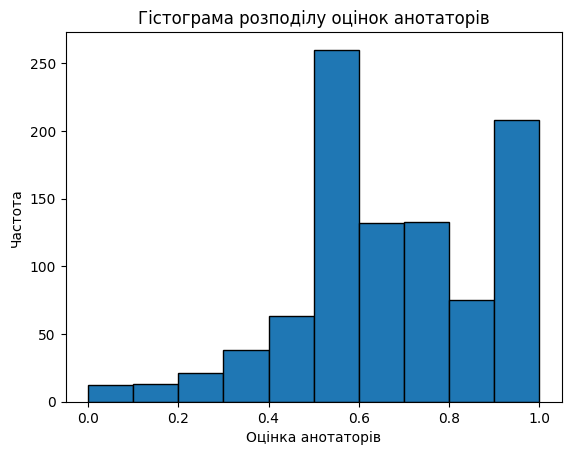

In [106]:
import numpy as np
import matplotlib.pyplot as plt
llm_scores = np.array(output)
# Plot histogram
plt.hist(llm_scores, bins=10, edgecolor='black')
plt.title("Гістограма розподілу оцінок анотаторів")
plt.xlabel("Оцінка анотаторів")
plt.ylabel("Частота")

plt.savefig("histogram.jpg")

In [107]:
from scipy import stats


stat, p = stats.shapiro(llm_scores)
print(f"Shapiro-Wilk: stat={stat:.4f}, p={p:.4f}")
if p > 0.05:
    print("Likely normal (fail to reject H0)")
else:
    print("Likely not normal (reject H0)")

Shapiro-Wilk: stat=0.9556, p=0.0000
Likely not normal (reject H0)


In [17]:
with open("output.png", "wb") as f:
    f.write(output["artifact_map"].bytes_list.value[0])

In [2]:
from datasets import load_dataset

ds = load_dataset("yuvalkirstain/pickapic_v1", split="test", streaming=True)

Resolving data files:   0%|          | 0/387 [00:00<?, ?it/s]

In [3]:
elements = ds.take(100000)

In [ ]:
from torch.utils.data import DataLoader

def search_for_image(uid : str):
    ds_words = ds.select_columns(["caption", "best_image_uid", "jpg_0","jpg_1", "image_0_uid", "image_1_uid"])
    idx = 0
    for example in ds_words:
        if (example["caption"]) == "Realistic owl":
            print(example["caption"])
            prompt = example["caption"]
            image = example["jpg_0"]
            with open(f"test_1.png", "wb") as f:
                f.write(example["jpg_0"])
            print(example["image_0_uid"])
            return image,prompt

        idx+=1
        if example["best_image_uid"] in uid or \
        example["image_0_uid"] in uid or  \
        example["image_1_uid"] in uid:

            if example["image_0_uid"]==uid:
                print("0")
                image = example["jpg_0"]
            else:
                print('1')
                image = example["jpg_1"]
            print(example["caption"])
            with open(f"{uid}_0.png", "wb") as f:
                f.write(example["jpg_0"])
            with open(f"{uid}_1.png", "wb") as f:
                f.write(example["jpg_1"])
                
            prompt = example["caption"]
            return image,prompt
    return None,None
        

In [51]:
import time
beg = time.time()
image,prompt = search_for_image(uid="abracadabra")
print(f"{time.time()-beg}")

Realistic owl
5fe3d0f2-1843-429a-87ec-10f360a9f5f5
Realistic owl
e603558c-e85e-4a62-ba91-90cdfb9eb1ae
Realistic owl
5fe3d0f2-1843-429a-87ec-10f360a9f5f5
Realistic owl
12a3b600-7a51-4b4f-87b7-97c0c06b7bf1


KeyboardInterrupt: 

In [95]:
prompt

'A cat, chubby, very fine wispy and extremely long swirly wavy fur, under water, Kuniyoshi Utagawa, Hishida Shunsō, a very curvy chubby cat, golden embroidery fabric kimono, flowing glowing biomorphic wisps, phosphorescent swirls, tendrils, wavelets, streamers, a murmuration of bioluminescent bubbles, ,  detailed and intricate, elegant aesthetic, ornate, finely detailed, 128K UHD  Unreal Engine, octane, fractal pi, fBm'

In [16]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import io
def calculate_clip_similarity(image_path, text, model_name="openai/clip-vit-base-patch32"):
    """
    Calculate the CLIP similarity score between an image and text.
    
    Args:
        image_path: Path to image file or URL
        text: Text to compare with the image
        model_name: CLIP model to use
        
    Returns:
        similarity_score: Cosine similarity between image and text embeddings
    """
    # Load model and processor
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)
    
    # Load image
 
    image = Image.open(io.BytesIO(image_path))
        
    # Process inputs
    inputs = processor(
        text=[text],
        images=image,
        return_tensors="pt",
        padding=True
    )
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        
    # Calculate similarity (cosine similarity)
    image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(text_embeds, image_embeds.T)[0][0].item()
    
    return similarity


In [7]:
calculate_clip_similarity(image_path=image,text=prompt)

0.33038726449012756

In [5]:
import re

def extract_alignment_score(text):
    match = re.search(r"Alignment Score:\s*([\d\.]+)", text)
    return float(match.group(1)) if match else None

In [10]:
from pydantic import BaseModel


class Model(BaseModel):
    alignment_score: float

In [7]:
human_prompt_template = """
Task description:
In this task you will evaluate following metrics of image generated by AI.
Metrics: Artifact score of image, Text-Alignment(overall alignment image to promp), Aesthetics 
To correctly make evaluation follow the INSTRUCTIONS
**INSTRUCTIONS**:
1. Understand the Textual Prompt
    a. Extract the core meaning of the prompt.
    b. Identify key elements such as objects, actions, relationships, emotions, colors, styles, or any specific details mentioned.
2. Analyze reference images with ground truth metrics, carefully learn why reference images got that metrics.

3. Analyze the Image
    a. Identify the main subjects, objects, actions, and visual characteristics of the image.
    b. Consider elements such as composition, colors, textures, and details that align with the prompt.
4. Rate image in 3 metrics based on evaluation criteria(0 worst, 1 best)

**Evaluation critera**
#### Evaluation criteria for Text Alignemt
1. Check if the main objects and actions in the prompt appear in the image.
2. Assess semantic alignment (e.g., if the prompt describes a "red apple," ensure a red apple is present rather than a green one).
3. Consider stylistic and contextual alignment (e.g., if the prompt asks for "a realistic portrait," but the image is abstract, the alignment is lower).

1.0 → Perfect match (The image fully matches the prompt in all aspects).
0.8 - 0.9 → High alignment (Minor deviations in details but the overall meaning is correct).
0.5 - 0.7 → Partial match (Some elements are missing or incorrect, but the general idea is preserved).
0.2 - 0.4 → Low alignment (The image and prompt share few relevant elements).
0.0 - 0.1 → No alignment (The image does not represent the prompt at all).


#### Evaluation criteria for Artifact score
    1. Texture and detail inconsistencies (e.g., unnatural blurring, overly smooth textures)
    2. Anatomical or structural errors (e.g., extra fingers, distorted faces, asymmetry)
    3. Lighting and reflection mismatches (e.g., inconsistent shadows, unnatural glow)
    4. Edge artifacts or unnatural blending (e.g., merging of objects, unrealistic transitions)
    5. Patterns in fine details (e.g., repetitive noise, lack of randomness in natural textures)

    1.0 → (The image looks really natural without any visible artifacts).
    0.8 - 0.9 → (Image has small artifact or some objects are misaligned).
    0.5 - 0.7 → (The image has noticeable artifacts or unnatural elements.).
    0.2 - 0.4 → (The image has multiple artifacts or unnatural distortions.).
    0.0 - 0.1 → (The image is heavily distorted or unnatural.).

#### Evaluation criteria for Aesthetics
    1. Check overall image sharpness and quality
    2. Analyze color palette cohesiveness and appropriateness
    3. Check how well looking is image at all
    
    1.0 → (The image is well looking).
    0.8 - 0.9 → (The image has unsignificant flaws on it or is not sharp enough).
    0.5 - 0.7 → (The image has significant flaws).
    0.0 - 0.4 → (The image is bad looking, it can be either not sharp enough or have a lot of flaws and artifacts on it).
5. As response return all metrics with all your thougts and comments
"""

In [54]:
prev_version_prompt = """ You are helpful assistant. You will be provided with description and image. Your goal is to determine how good image align with the description. 
                            Follow instructions step by step and verify each step.
                            Instruction:
                            Steps to Evaluate Alignment

                            1. Understand the Textual Prompt
                                a. Extract the core meaning of the prompt.
                                b. Identify key elements such as objects, actions, relationships, emotions, colors, styles, or any specific details mentioned.

                            2. Analyze the Image
                                a. Identify the main subjects, objects, actions, and visual characteristics of the image.
                                b. Consider elements such as composition, colors, textures, and details that align with the prompt.

                            3. Compare Textual and Visual Features
                                a. Check if the main objects and actions in the prompt appear in the image.
                                b. Assess semantic alignment (e.g., if the prompt describes a "red apple," ensure a red apple is present rather than a green one).
                                c. Consider stylistic and contextual alignment (e.g., if the prompt asks for "a realistic portrait," but the image is abstract, the alignment is lower).

                            4. Assign an Alignment Score (0-1 Scale)
                                1.0 → Perfect match (The image fully matches the prompt in all aspects).
                                0.8 - 0.9 → High alignment (Minor deviations in details but the overall meaning is correct).
                                0.5 - 0.7 → Partial match (Some elements are missing or incorrect, but the general idea is preserved).
                                0.2 - 0.4 → Low alignment (The image and prompt share few relevant elements).
                                0.0 - 0.1 → No alignment (The image does not represent the prompt at all).
                            5. As response return ONLY Alignment score as number without any additional thoughts and comments
                            """

In [6]:
multi_expert = """

## Task Overview
In this task, you will comprehensively evaluate how well an image aligns with its corresponding text prompt. You will analyze this alignment from multiple expert perspectives, following a structured methodology to arrive at a final alignment score.

## Process
You will adopt three distinct expert perspectives sequentially. Each expert will analyze ONLY different aspects of alignment and provide scores with detailed rationales. Begin with Expert 1, then Expert 2,Expert 3, and conclude with Expert 5's synthesis.
Expert 1 is Entity detection specialist, Expert 2 is Spatial Relation Specialist, Expert 3 is Activity verification Specialist
## Expert 1: Entity Detection Specialist
🚨 IMPORTANT: You are evaluating ONLY entity presence, NOT activities or spatial relationships. 
If the image includes extra entities not mentioned in the prompt (e.g., three cats when the prompt specifies two), it is a misalignment.

**INSTRUCTIONS**:
KEEP IN MIND THAT YOU ARE EVALUATING ONLY ENTITIES NOT ACTIVITIES
1. Carefully analyze the text prompt and extract ALL entities, categorizing them as follows: EXTRACT ONLY ENTITIES NOT ACTIVITIES
   - Primary entities: Main subjects
   - Secondary entities: Supporting elements that add context
   - Attributes: Specific qualities described (colors, textures, etc.)

2. For each entity and attribute, evaluate representation quality in the image using this scale:
   - Excellent (1.0): Entity appears exactly as described
   - Good (0.8): Entity appears with minor deviations
   - Partial (0.5): Entity is present but significantly different
   - Poor (0.2): Entity is barely recognizable or ambiguous
   - Missing (0.0): Entity is completely absent


EXAMPLE:
> Prompt: "A white wolf standing on a snowy mountain peak, gazing at the full moon"
> 
> Primary entities:
> - Wolf (1.0) - Clearly visible as the main subject
> - Mountain peak (0.8) - Present but less prominent than expected
> - Moon (1.0) - Clearly visible in the background
>
> Secondary entities:
> - Snow (1.0) - Covers the mountain appropriately
>
> Attributes:
> - White (wolf) (0.7) - Wolf is more grey than white
> - Full (moon) (0.8) - Moon appears round but not quite full
>

> ENTITY DETECTION SCORE: 0.8 - High alignment with nearly all entities represented well. The mountain peak is slightly less prominent than expected, and the moon isn't quite full.

Return your score and your thoughts and comments
## Expert 2: Activity Relations Analyst
YOUR ROLE: Composition expert focusing on relationships, positioning, and interactions between elements.

### Instructions
1. Extract all spatial and interactive relationships between entities in the prompt.
   - Positional relationships (above, below, inside, next to)
   - Directional relationships (facing, moving toward)
   - Interactive relationships (touching, holding, using)
   - Scale relationships (larger than, smaller than)

2. Evaluate how accurately each relationship is represented using this scale:
   - Perfect (1.0): Relationship depicted exactly as described
   - Accurate (0.8): Relationship present with minor inaccuracies
   - Partial (0.5): Relationship present but significantly altered
   - Minimal (0.2): Relationship barely perceptible or highly distorted
   - Absent (0.0): Relationship completely missing

3. Assess perspective, depth, and scale consistency across the image.

EXAMPLE:
> Prompt: "A white wolf standing on a snowy mountain peak, gazing at the full moon"
>
> Spatial relationships:
> - Wolf ON mountain peak (0.9) - Wolf is clearly positioned on what appears to be a mountain peak
> - Wolf GAZING AT moon (1.0) - Wolf's head and eyes are directed toward the moon
>
> Perspective analysis:
> - The perspective shows the wolf from a side angle, allowing clear visibility of both the wolf and the moon (1.0)
> - Scale appears natural between elements (0.9) - The wolf and mountain proportions are appropriate
>
> SPATIAL RELATIONS SCORE: 0.95 - The spatial relationships defined in the prompt are represented with high accuracy.


## Expert 3: Activity Verification Specialist
YOUR ROLE: Behavioral analyst ensuring all described actions, activities, and dynamic elements are accurately depicted.

### Instructions
1. Identify all activities, actions, and dynamic states mentioned in the prompt:
   - Explicit actions (running, eating, building)
   - States that imply motion or action (dancing waves, flowing river)
   - Emotional expressions (smiling, crying, laughing)

2. Evaluate how accurately each activity is represented using this scale:
   - Perfect (1.0): Activity depicted exactly as described, with appropriate posture and context
   - Accurate (0.8): Activity recognizable with minor deviations in execution
   - Partial (0.5): Activity suggested but not clearly or convincingly portrayed
   - Minimal (0.2): Activity barely implied or highly ambiguous
   - Absent (0.0): Activity completely missing

3. Consider the naturalness and believability of the activities.

EXAMPLE:
> Prompt: "A white wolf standing on a snowy mountain peak, gazing at the full moon"
>
> Activities:
> - STANDING (0.9) - Wolf is clearly on all fours in a standing position on the peak, though slightly hunched rather than fully erect
> - GAZING (1.0) - Wolf's head position, eye direction, and overall posture convincingly convey the act of gazing at the moon
>
> Action naturalness:
> - The wolf's stance appears natural and anatomically correct (1.0)
> - The gazing behavior is portrayed with appropriate wolf body language (0.9)
>
> ACTIVITY VERIFICATION SCORE: 0.95 - The activities described in the prompt are portrayed with high fidelity and natural execution.

## Expert 4: Holistic Alignment Evaluator
YOUR ROLE: Senior evaluator synthesizing previous analyses into a comprehensive alignment assessment.

### Instructions
1. Review and analyze the rationales provided by Experts 1, 2, and 3.

2. Consider additional factors:
   - Artistic/stylistic alignment with implied prompt tone
   - Contextual appropriateness
   - Semantic coherence
   - Overall visual impact

3. Calculate the final alignment score using this weighted formula:
   - Final Score = (0.3 × Entity Score) + (0.3 × Spatial Score) + (0.3 × Activity Score) + (0.1 × Contextual Factors)

4. Provide your score with a detailed rationale explaining strengths and weaknesses in alignment.


EXAMPLE:
> FINAL ALIGNMENT EVALUATION
>
> Entity Score: 0.9
> Spatial Relations Score: 0.95
> Activity Verification Score: 0.95
> Contextual Factors Score: 0.85 - The image captures the implied mood of wilderness and solitude, though lighting could better emphasize the moonlight.
>
> Weighted Calculation:
> (0.3 × 0.9) + (0.3 × 0.95) + (0.3 × 0.95) + (0.1 × 0.85) = 0.925
>
> FINAL ALIGNMENT SCORE: 0.93 (High Alignment)
>
> Rationale: The image successfully represents all key entities, spatial relationships, and activities from the prompt. The wolf, mountain, and moon are clearly depicted with the correct positioning and orientation. The activities of standing and gazing are convincingly portrayed with natural body language. Minor deviations include the mountain peak being slightly less prominent than might be expected and the moon not appearing completely full. The overall mood and context align well with the prompt's implications.
>
> To achieve perfect alignment: The mountain peak could be more dramatic, the moon could be more clearly full, and the lighting could better emphasize moonlight on the snow.

"""

In [8]:
multi_expert = """

## Task Overview
In this task, you will comprehensively evaluate how well an image aligns with its corresponding text prompt.
You will analyze this alignment from multiple INDEPENDENT expert perspectives, following a structured methodology to arrive 5 different scores.
# Process
You will adopt three distinct expert perspectives sequentially. Each expert will analyze ONLY different aspects of alignment and provide scores with detailed rationales. Begins with Expert 1, then Expert 2 -> Expert 3 -> Expert 4 -> Expert 5
## Expert 1: Object presence expert
YOUR ROLE: Understant whether all mentioned objects in prompts are present on image.
**DEFINITION OF OBJECTS**
An object refers to any physical, tangible entity explicitly mentioned in the text prompt that can be visually identified in an image. 
Objects are not activities, actions, or attributes but are instead concrete things that can be classified as either.

**INSTRUCTIONS**
1. Carefully analyze the text prompt and extract ALL entities, categorizing them as follows: EXTRACT ONLY ENTITIES NOT ACTIVITIES and ATTRIBUTES
   - Primary entities: Main subjects
   - Secondary entities: Supporting elements that add context
2. Carefully analyze image and evaluate using following scale:
   - Excellent (1.0): Objects appears exactly as described
   - Good (0.8): Objects appears with minor deviations
   - Partial (0.5): Objects is present but significantly different
   - Poor (0.2): Objects is barely recognizable or ambiguous
   - Missing (0.0): Objects is completely absent
   - None: No objects in textual prompt are mentioned, therefore score can not be assigned
3. Return your score and your thoughts and comments

EXAMPLES:
EXAMPLE 1:
 Prompt: "A young girl holding a yellow balloon in a park."

IMAGE: [young girl with a yellow balloon in park]

 Primary entities:
 - Girl (1.0) - Clearly visible as the main subject
 - Balloon (0.8) - Present but less prominent than expected

 Secondary entities:
 - Park (1.0) - Park is properly visible and clearly distinctive

 OBJECT PRESENCE SCORE: 0.9 - High alignment with nearly all entities represented well

EXAMPLE 2:
 Prompt: "A black cat sitting on a wooden table near a cup of coffee."

 IMAGE: [A black cat sitting on a wooden surface with no cup nearby.]

 Primary entities:
 - Cat (1.0) - Clearly visible as the main subject
 - Cap (0.0) - Cap is missing

 Secondary entities:
 - Wooden table (0.6) - Surface is not distinctive enough to be table

 OBJECT PRESENCE SCORE: 0.5 - Partial alignment with major object missing

## Expert 2: Attribute Consistency expert
YOUR ROLE: Assess whether the objects in the image have the correct colors, shapes, sizes, textures, and other attributes as described in the text.
**DEFINITION OF SPATIAL RELATIONSHIPS**
An attribute refers to any descriptive quality explicitly mentioned in the text prompt that characterizes an object. Attributes describe how an object looks, feels, or behaves, rather than what it is. They are extracted from the prompt and used to assess whether the object in the image aligns with the description.
Types of Attributes

    Color – The object's hue or shade (e.g., "red dress," "black cat").

    Shape – The object's form or structure (e.g., "round table," "triangular sign").

    Size – The object's relative dimensions (e.g., "tiny house," "large elephant").

    Texture – The object's surface feel (e.g., "rough rock," "smooth fabric").

    Material – What the object is made of (e.g., "wooden table," "metal pole").

    Other Descriptive Qualities – Additional properties that define the object's state (e.g., "steaming coffee," "glowing light").
    
**INSTRUCTIONS**
1. Extract Attributes from the Text Prompt:
   - Identify all attributes explicitly mentioned in the prompt.
   - Attributes include: Color, Shape, Size, Texture, Material and Other Descriptive Qualities.

2. Carefully analyze image and evaluate using following scale:
    - Excellent (1.0): Attribute perfectly matches the description.
    - Good (0.8): Minor deviations from the description, but still mostly accurate.
    - Partial (0.5): Attribute is present but significantly different from the expected description.
    - Poor (0.2): Attribute is barely recognizable or ambiguous.
    - Missing (0.0): Attribute is completely absent.
    - None: No attributes in textual prompt are mentioned, therefore score can not be assigned
3. Return your score and your thoughts and comments
EXAMPLES:
Example 1
Prompt: "A young girl wearing a red dress holding a yellow balloon in a park."
IMAGE: [A young girl in a pink dress holding a yellow balloon in a park.]
Extracted Attributes:
    Girl's dress (Red) → (0.5) Partial (Dress is pink, not red)
    Balloon (Yellow) → (1.0) Excellent (Color matches exactly)
    Park setting → (1.0) Excellent (Background is clearly a park)
ATTRIBUTE CONSISTENCY SCORE: 0.83 – Mostly consistent with minor color deviation.
Example 2
Prompt: "A black cat sitting on a round wooden table near a steaming cup of coffee."
IMAGE: [A black cat sitting on a square wooden table near a coffee cup with no visible steam.]
Extracted Attributes:
    Cat's color (Black) → (1.0) Excellent (Color matches exactly)
    Table shape (Round) → (0.2) Poor (Table is square, not round)
    Table material (Wooden) → (1.0) Excellent (Clearly wooden)
    Coffee cup steam (Steaming) → (0.0) Missing (No steam visible)
ATTRIBUTE CONSISTENCY SCORE: 0.55 – Partial consistency due to shape and steam discrepancies.
Expert 3: Incorrect Numbers Expert

YOUR ROLE: Assess whether the counts of humans, animals, or objects in the image match the numbers specified in the text.

DEFINITION OF NUMERIC CONSISTENCY
Numeric consistency refers to ensuring that the number of items (humans, animals, or objects) described in the text corresponds to what is visually represented in the image. This includes verifying the exact counts or identifying any discrepancies.

Types of Numerical Elements:

    Humans – The number of people described in the text (e.g., "three children").

    Animals – The number of animals in the image (e.g., "two dogs").

    Objects – The count of specific items or objects mentioned (e.g., "four chairs," "five apples").

INSTRUCTIONS

    Extract Numerical Information from the Text Prompt:

        Identify all explicit numbers or counts in the prompt.

        Include humans, animals, and objects as necessary.

    Analyze the Image to Count Humans, Animals, and Objects:

        Perform a count of the humans, animals, and objects visible in the image.

        Compare the counts with the numbers specified in the text prompt.

    Evaluation Scale:

        Excellent (1.0): The numbers in the image exactly match the description in the prompt.

        Good (0.8): The numbers are mostly correct, with only a minor discrepancy (e.g., one object or person is missing or extra).

        Partial (0.5): There is a significant difference in the number of items in the image compared to the description.

        Poor (0.2): The number of items is drastically incorrect (e.g., 3 people are described, but only 1 is in the image).

        Missing (0.0): No numeric references are made in the text prompt, making it impossible to assess.

    Return your score and your thoughts and comments on whether the image accurately represents the counts specified in the text.

EXAMPLES:
Example 1
Prompt: "Two dogs playing in the yard."
IMAGE: [One dog playing in the yard.]
Extracted Numbers:
Dogs (Two) → (0.2) Poor (Only one dog is present, although two were described)
NUMERIC CONSISTENCY SCORE: 0.2 – The count of dogs in the image does not match the description.

Example 2
Prompt: "Four apples on a table."
IMAGE: [Four apples on the table.]
Extracted Numbers:
Apples (Four) → (1.0) Excellent (The image shows exactly four apples as described)
NUMERIC CONSISTENCY SCORE: 1.0 – The count is exactly as expected.

## Expert 4: Position Expert
YOUR ROLE: Assess if objects in the image are positioned according to the correct positions described in the text.
**DEFINITION OF POSITION**
Position refers to the relative positioning and orientation of objects in an image as described in a text prompt. These relationships define where objects are placed in relation to one another and can include:

    Positioning Terms – Describe how objects are situated relative to each other (e.g., next to, above, below, behind, in front of, on top of, inside, outside, between).

    Directional Indicators – Specify the direction of an object within the frame (e.g., left, right, center, top, bottom).

    Distance Indicators – Indicate how far objects are from each other (e.g., close to, far from, near).

What is NOT a Position?

    Objects Themselves (e.g., "dog," "tree")

    Attributes of Objects (e.g., "red car," "wooden table")

    Actions or Activities (e.g., "running," "sitting")
**INSTRUCTIONS**

    1. Extract Positions from the Text Prompt:
        Identify positions described in the prompt, such as:
            - Positioning terms: next to, above, below, behind, in front of, beside, near, on top of, inside, outside, between and more.
            - Directional indicators: left, right, center, top, bottom.
        Ensure to account for both relative positions (e.g., "next to" or "on top of") and distance (e.g., "close," "far away").
    2. Carefully analyze image and evaluate using following scale:
        Compare the positioning of the objects in the image based on the positions extracted from the prompt.

        Use the following rating scale to assess the alignment of positions:
            - Excellent (1.0): Objects are positioned exactly as described in the prompt.
            - Good (0.8): Objects are positioned with minor deviations, but still close to the intended position.
            - Partial (0.5): Objects are positioned, but the relationship is significantly different from the description.
            - Poor (0.2): The position is barely recognizable or ambiguous.
            - Missing (0.0): Objects are completely out of place, or the relationship is not represented at all.
            - None: No position in textual prompt are mentioned, therefore score can not be assigned


EXAMPLES:
Example 1
Prompt: "A dog sitting next to a tree."
IMAGE: [A dog sitting on the left side of a tree, with a small distance between them.]
Extracted Spatial Relationships:
    Dog (Next to) Tree → (0.8) Good (Dog is near the tree, but there is a slight gap)
SPATIAL RELATIONSHIP SCORE: 0.8 - Close alignment with minor deviation in positioning.

Example 2
    Prompt: "A man standing behind a red car."
    IMAGE: [A man is positioned in front of a red car, not behind it.]
    Extracted Spatial Relationships:
        Man (Behind) Red Car → (0.0) Missing (Man is in front of the car)
    SPATIAL RELATIONSHIP SCORE: 0.0 - Spatial relationship is completely incorrect.

## Expert 5: Activity Verification Expert

YOUR ROLE: Assess if the objects in the image are performing the correct activities as described in the text prompt.
**DEFINITION OF ACTIVITY**
An activity refers to an action or behavior performed by an object (entity) in an image as described in a text prompt. Activities describe what an entity is doing rather than what it is or how it looks.

    Action Verbs – Indicate explicit activities (e.g., walking, sitting, eating, running, jumping, holding, carrying).

    Contextual Details – Provide additional information about how the activity is performed (e.g., "A man sitting on a bench," "A dog playing with a ball").

What is NOT an Activity?

    Objects Themselves (e.g., "man," "dog")

    Attributes of Objects (e.g., "red dress," "round table")

    Spatial Relationships (e.g., "next to," "behind")
**INSTRUCTIONS**
    1. Extract Activities from the Text Prompt:

        - Identify activities or actions described in the prompt.
        - Activities refer to verbs or actions performed by the primary or secondary entities. Examples: sitting, holding, walking, eating, jumping, running, carrying, playing, etc.
        - Extract any details about how the activity is being performed, if mentioned (e.g., "The man is sitting on the chair," "The dog is playing with a ball").

    2. Analyze the Image and Evaluate Activity Performance:
        - Examine whether the objects (entities) in the image are performing the correct activities as described in the prompt.
        - Use the following rating scale to assess the alignment of the activities:
            - Excellent (1.0): Objects are performing the exact activities as described.
            - Good (0.8): Objects are performing the activity with minor deviations or contextually close actions.
            - Partial (0.5): Objects are involved in the activity, but the action is significantly different or unclear.
            - Poor (0.2): Objects are performing an ambiguous or wrong activity.
            - Missing (0.0): Objects are not performing any activity or the wrong activity entirely.
            - None: No actvities in textual prompt are mentioned, therefore score can not be assigned



EXAMPLES:
Example 1

    Prompt: "A dog playing with a ball in the yard."

    IMAGE: [A dog running with a ball in its mouth in a yard.]

    Extracted Activities:

        Dog (Playing) with Ball → (1.0) Excellent (Dog is playing with a ball)

    ACTIVITY VERIFICATION SCORE: 1.0 - Perfect alignment with the described activity.

Example 2

    Prompt: "A girl holding a book in her hand while walking down the street."

    IMAGE: [A girl walking down the street with a book in her hand, but she seems to be looking around, not engaged in reading.]

    Extracted Activities:

        Girl (Holding) Book → (1.0) Excellent (Girl is holding the book as described)

        Girl (Walking) → (1.0) Excellent (Girl is walking down the street)

    ACTIVITY VERIFICATION SCORE: 1.0 - Perfect alignment with the described activities.

Example 3

    Prompt: "Asian man in goth style"

    IMAGE: [Asian man in goth style]

    Extracted Activities:
        - No activities extracted

    ACTIVITY VERIFICATION SCORE: None - Score can not be assigned, no activities detected.
"""

In [9]:
from pydantic import BaseModel,Field
class Model(BaseModel):
    reasoning_of_expert_1: str = Field(...,
        description="Explanation of EXPERT 1 the step-by-step thought process behind the provided values. Include key considerations and how they influenced the final decisions."
    )
    reasoning_of_expert_2: str = Field(...,
        description="Explanation of EXPERT 2 the step-by-step thought process behind the provided values. Include key considerations and how they influenced the final decisions."
    )
    reasoning_of_expert_3: str = Field(...,
        description="Explanation of EXPERT 3 the step-by-step thought process behind the provided values. Include key considerations and how they influenced the final decisions."
    )

    reasoning_of_expert_4: str = Field(...,
        description="Explanation of EXPERT 4 the step-by-step thought process behind the provided values. Include key considerations and how they influenced the final decisions."
    )
    reasoning_of_expert_5: str = Field(...,
        description="Explanation of EXPERT 5 the step-by-step thought process behind the provided values. Include key considerations and how they influenced the final decisions."
    )
    score_of_expert_1: float | None
    score_of_expert_2: float | None
    score_of_expert_3: float | None
    score_of_expert_4: float | None
    score_of_expert_5: float | None

In [11]:
from pydantic import Field


class Model(BaseModel):
    reasoning: str = Field(...,
        description="Explain the step-by-step thought process behind the provided values. Include key considerations and how they influenced the final decisions."
    )

    alignment_score: float

In [7]:
system_prompt_evaluator_enhanced = """
CAREFULLY FOLLOW INSTRUCTIONS. Lets think step by step.

Task description:
In this task, you will evaluate one metric of an image generated by AI: **Text-Alignment** (how well the image matches the prompt).
To correctly make the evaluation, follow the instructions carefully.

**INSTRUCTIONS**:
1. Understand the Textual Prompt
    a. Extract the core meaning of the prompt.
    b. Identify key elements such as objects, actions, relationships, emotions, colors, styles, or any specific details mentioned.
    c. Identify number of objects. Try to identift nynber of iob
    
    Example:
    - Prompt: "A realistic painting of a golden retriever playing with a red ball in a sunny park."
    - Core elements: realistic painting, golden retriever, playing, red ball, sunny park.
    

2. Analyze the Image
    a. Identify the main subjects, objects, actions, and visual characteristics.
    b. Consider composition, colors, textures, lighting, and overall fidelity to the prompt.
    c. Pay attention to the number of objects

    Example:
    - Does the dog breed match a golden retriever?
    - Is the ball red?
    - Is the park bright and sunny?
    - Is the painting style realistic or abstract?
  
3. Rate the image using the Text-Alignment metric (0 = worst, 1 = best)

**Evaluation Criteria for Text Alignment**
1. Check if the main objects and actions described in the prompt are present in the image and are clearly and accurately represented.
2. Assess semantic alignment:
    - If the prompt says “a red apple,” and the image has a green apple — this is a mismatch.
3. Consider stylistic and contextual alignment:
    - If the prompt says “a sketch of a city skyline at night,” but the image is a photorealistic rendering, the style is not aligned.

**Examples of Alignment Ratings**:

- **1.0** → *Perfect match*:  
  Prompt: "A watercolor painting of a white cat sleeping on a windowsill during winter."  
  Image: A delicate watercolor showing a white cat curled up on a snowy windowsill.

- **0.8 - 0.9** → *High alignment*:  
  Prompt: "A pirate ship in a thunderstorm, viewed from above."  
  Image: A ship with pirate flags in stormy waters, but viewed from the side rather than above.


- **0.5 - 0.7** → *Partial match*:  
  Prompt: "A dragon flying over a medieval village at sunset."  
  Image: A dragon is present, but the background is a modern city at night.
  Prompt: "red apple on a wooden table."
  Image: "red apple(which is full of artifacts) on a wooden table."
  
- **0.2 - 0.4** → *Low alignment*:  
  Prompt: "A child blowing bubbles in a summer field."  
  Image: A child is sitting in a park, but there are no bubbles or summery elements.

- **0.0 - 0.1** → *No alignment*:  
  Prompt: "An astronaut floating in space holding a bouquet of flowers."  
  Image: A close-up of a cat sitting indoors.

---

**Response Format** (Return all your thoughts and metrics in JSON):

{
  "rationale": "The image contains a golden retriever and a red ball in a park, but the style is cartoonish rather than realistic as the prompt asked. Lighting suggests daytime, aligning with 'sunny'. Overall, the image captures the key ideas with a minor stylistic mismatch.",
  "alignment_score": 0.85
}

"""

In [ ]:
import base64
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv()

client = OpenAI()

def llm_score(image, caption):
    image_base64 = base64.b64encode(image).decode("utf-8")
    #print(f"Base 64: {image_base64}")
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        temperature=0.0,
        top_p=1.0,
        response_format=Model,
        logprobs=True,
        top_logprobs=5,
        messages=[
            {
                "role": "system",
                "content": [{
                    "type":"text", 
                    "text": multi_expert
            }],
            },
            {
                "role": "user",
                "content": [
                        {
                        "type": "text",
                        "text": f"Text prompt: {caption}",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{image_base64}", "detail":"high"},
                    },

                ],
            }
        ],
    )
    output = response.choices[0].logprobs.content[0].top_logprobs
    print(response.choices[0].message.parsed)
    return response


In [11]:
output = llm_score(image, prompt)

reasoning_of_expert_1='The prompt specifies a "Golden retriever" and a "baseball". In the image, there is a golden retriever clearly visible, which matches the primary entity perfectly. The baseball is also present, flying through the air, which aligns with the prompt\'s description of the dog playing with it. Both primary entities are present and identifiable, leading to a high score for object presence.' reasoning_of_expert_2='The attributes extracted from the prompt include the color of the dog (golden retriever) and the object (baseball). The dog in the image is indeed a golden retriever, matching the color and breed perfectly. The baseball is also present and appears as expected. Therefore, the attributes are consistent with the description, resulting in a high score for attribute consistency.' reasoning_of_expert_3='The prompt does not specify a number of dogs or baseballs, but it implies one of each. In the image, there is one golden retriever and one baseball, which matches the

In [23]:
import numpy as np


top_two_logprobs = output.choices[0].logprobs.content[404].top_logprobs
html_content = ""
for i, logprob in enumerate(top_two_logprobs, start=1):
    print(
        f"Output token {i}: {logprob.token}, \n"
        f"logprobs: {logprob.logprob}, \n"
        f"linear probability: {np.round(np.exp(logprob.logprob)*100,2)}\n",
        "====================\n"
    )


Output token 1: 3, 
logprobs: 0.0, 
linear probability: 100.0

Output token 2: !, 
logprobs: -100.0, 
linear probability: 0.0

Output token 3: ", 
logprobs: -100.0, 
linear probability: 0.0

Output token 4: #, 
logprobs: -100.0, 
linear probability: 0.0

Output token 5: $, 
logprobs: -100.0, 
linear probability: 0.0



In [13]:
human_score = []
clip_score_results = []
llm_score_results = []
def parse_tfrecord_file(filename):
  """Parses a TFRecord file and prints the contents."""

  raw_dataset = tf.data.TFRecordDataset(filename)
  

  for idx, raw_record in enumerate(raw_dataset):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feat_map = example.features.feature

    # Original filename which can be mapped to images in pick-a-pic dataset.
    filename = feat_map['filename'].bytes_list.value[0].decode()
    misalignment_score = feat_map['misalignment_score'].float_list.value[0]

    uid = filename.split(sep="/")[1].split(sep=".")[0]
    print(uid)
    image, prompt = search_for_image(uid=uid)
    clip_score_results.append(calculate_clip_similarity(text=prompt,image_path=image))
    #print('Filename:', filename)
    #print(feat_map)
    #print(feat_map['prompt_misalignment_label'])
    human_score.append(misalignment_score)
    llm_score_results.append(llm_score(caption=prompt, image=image))
    print(idx)

    if idx > 2:
      break


In [14]:
print(human_score)
print(llm_score_results)
print(clip_score_results)

[]
[]
[]


In [17]:
parse_tfrecord_file("dataset/test.tfrecord")

bf07713d-b61a-4323-9515-7e9c4a70253b
Two cats watering roses in a greenhouse
0
bd0bacd9-4949-4e64-ba70-fad40e4221cb
A broken pot floating on water
1
9a8be82a-9d8f-48e8-b394-340b2d0303ca
Fru fru
2
b9f7c968-0681-4a0d-838d-22b15aab1605
cyberpunk mutant cute blond girl
3


In [95]:
import scipy.stats as stats
kendall_tau, _ = stats.pearsonr(clip_score_results, human_score)
print(kendall_tau)

kendall_tau, _ = stats.pearsonr(llm_score_results, human_score)
print(kendall_tau)


0.09046628379994194


ValueError: data type <class 'numpy.object_'> not inexact

In [18]:
for element,h in zip(llm_score_results,human_score):
    print(element.final_alignment_score, h)

0.69 0.5
0.99 0.75
0.93 0.0
0.9 1.0


In [29]:
image,prompt = search_for_image(uid="bf07713d-b61a-4323-9515-7e9c4a70253b")


Two cats watering roses in a greenhouse


In [30]:
prompt

'Two cats watering roses in a greenhouse'

In [31]:
output = (llm_score(caption=prompt, image=image))
print(output.reasoning_of_expert_3)

In this prompt, the activities described are the cats watering the roses. However, the image does not depict any action of watering; instead, the cats are simply positioned near the roses, with one cat appearing to touch the rose. This lack of action is a major deviation from the prompt. The cats are not shown in a dynamic state of watering, which is a critical aspect of the prompt. 

Activities:
- WATERING (0.0) - The activity of watering is completely absent in the image.

The naturalness of the cats' behavior is somewhat present, as they appear curious about the roses, but this does not fulfill the prompt's requirement for the specific action of watering. 

Activity Verification Score: 0.0 - The activity described in the prompt is completely missing from the image.


In [38]:
print(output.reasoning_of_final_expert)

After reviewing the analyses from Experts 1, 2, and 3, it is clear that while the entities are well represented, the activities and spatial relationships do not align with the prompt. The cats are present, and the roses are depicted beautifully, but the critical action of watering is entirely absent. This leads to a significant misalignment in the overall representation of the prompt. 

Entity Score: 0.95
Spatial Relations Score: 0.5
Activity Verification Score: 0.0
Contextual Factors Score: 0.7 - The image captures a whimsical and playful tone, but the lack of action detracts from the overall effectiveness. 

Weighted Calculation:
(0.3 × 0.95) + (0.3 × 0.5) + (0.3 × 0.0) + (0.1 × 0.7) = 0.385

Final Alignment Score: 0.39 (Low Alignment) - The image successfully represents the cats and roses, but the absence of the watering action leads to a significant misalignment with the prompt's intent. To achieve better alignment, the image should depict the cats actively watering the roses, enha

In [ ]:
llm_score = [0.68, 0.99, 1.0, 0.88, 0.97, 0.99, 0.0, 0.99, 0.76, 0.95, 1.0, 0.86, 0.25, 0.93, 1.0, 0.5, 1.0, 0.56, 0.96, 0.39, 1.0, 0.99, 0.93, 0.87, 0.89, 1.0, 0.99, 0.53, 0.93, 1.0, 0.69, 0.93, 0.9, 1.0, 0.96, 1.0, 0.2, 0.76, 0.93, 0.91, 0.99, 0.53, 0.93, 0.86, 0.38, 0.9, 0.79, 0.99, 1.0, 0.64, 0.77, 0.89, 0.81, 0.94, 0.99, 0.93, 1.0, 0.93, 0.99, 0.93, 0.83, 0.93, 0.99, 0.99, 0.83, 0.93, 0.79, 0.12, 1.0, 0.93, 0.91, 0.99, 0.82, 0.9, 0.23, 0.99, 0.59, 1.0, 0.94, 0.93, 0.7, 0.85, 1.0, 0.0, 0.99, 0.05, 0.93, 0.84, 0.0, 0.56, 0.99, 0.83, 0.86, 0.63, 0.97, 0.99, 1.0, 0.81, 0.93, 0.89, 0.79, 0.94, 1.0, 0.99, 0.93, 1.0, 1.0, 0.62, 0.94, 0.76, 0.74, 0.995, 0.24, 0.15, 0.87, 0.83, 0.94, 0.74, 0.99, 0.96, 0.83, 0.99, 0.9, 0.97, 0.85, 0.93, 0.97, 0.99, 0.68, 0.85, 1.0, 0.93, 1.0, 0.9, 1.0, 0.94, 0.73, 0.99, 0.39, 0.67, 0.29, 0.09, 1.0, 0.67, 0.99, 0.76, 0.76, 0.49, 1.0, 0.93, 0.38, 0.53, 0.805, 1.0, 0.0, 0.96, 0.98, 0.8, 0.56, 0.9, 0.23, 0.6, 1.0, 0.79, 0.49, 0.9, 0.86, 0.98, 0.29, 0.86, 0.99, 0.91, 0.83, 0.76, 1.0, 1.0, 1.0, 0.97, 0.74, 0.99, 1.0, 0.55, 0.93, 0.79, 0.3, 0.68, 0.59, 0.81, 0.92, 0.76, 0.99, 0.86, 0.97, 0.93, 1.0, 0.76, 0.53, 0.83, 0.38, 1.0, 0.29, 0.93, 0.3, 0.75, 0.735, 0.99, 0.76, 0.15, 1.0, 0.53, 0.99, 0.99, 0.11, 0.66, 1.0, 0.56, 1.0, 0.56, 1.0, 0.83, 0.23, 1.0, 0.99, 0.0, 1.0, 0.83, 0.79, 1.0, 0.79, 0.93, 0.14, 0.93, 0.81, 0.6, 0.95, 0.58, 0.99, 1.0, 0.99, 1.0, 0.81, 0.83, 0.0, 1.0, 0.73, 0.6, 0.86, 0.99, 0.59, 1.0, 0.97, 0.99, 0.93, 0.94, 0.75, 0.98, 0.93, 0.93, 0.97, 0.85, 0.99, 0.66, 0.78, 0.2, 0.99, 0.99, 0.87, 1.0, 0.84, 0.4, 0.99, 1.0, 0.9, 0.87, 0.83, 0.97, 0.87, 0.93, 0.83, 1.0, 0.6, 0.99, 0.22, 0.53, 0.99, 0.0, 1.0, 0.56, 1.0, 0.0, 1.0, 0.83, 0.43, 0.81, 0.89, 0.48, 0.98, 0.79, 0.89, 0.0, 0.99, 1.0, 0.89, 0.45, 0.1, 0.84, 0.25, 0.9, 1.0, 0.99, 0.52, 1.0, 0.69, 0.0, 0.99, 0.56, 0.15, 0.93, 0.93, 0.74, 0.93, 0.0, 0.93, 0.79, 0.93, 0.9, 0.78, 0.25, 0.99, 0.74, 0.93, 0.99, 0.83, 0.69, 0.83, 0.65, 0.29, 0.99, 1.0, 0.83, 0.9, 0.61, 0.97, 0.93, 0.99, 0.06, 0.79, 1.0, 0.68, 0.83, 1.0, 0.76, 0.89, 0.86, 0.93, 0.42, 1.0, 0.29, 0.93, 0.93, 0.9, 0.31, 1.0, 0.95, 0.98, 0.9, 0.73, 1.0, 0.66, 0.59, 1.0, 0.94, 0.38, 0.86, 0.91, 0.27, 0.49, 0.64, 1.0, 0.93, 0.73, 0.91, 0.76, 0.99, 0.79, 0.99, 0.91, 0.71, 1.0, 0.93, 0.93, 0.73, 0.97, 0.855, 0.9, 0.95, 0.87, 0.66, 0.99, 0.88, 0.99, 0.27, 0.93, 0.4, 0.93, 0.99, 0.83, 1.0, 1.0, 1.0, 1.0, 0.99, 0.97, 0.93, 0.94, 1.0, 0.38, 0.9, 0.48, 0.38, 0.83, 0.15, 0.79, 1.0, 0.77, 0.99, 1.0, 1.0, 0.93, 0.87, 0.995, 0.0, 0.29, 1.0, 0.3, 1.0, 0.9, 0.65, 1.0, 0.31, 0.93, 0.93, 0.9, 1.0, 0.93, 0.73, 0.73, 0.9, 0.97, 0.84, 0.99, 1.0, 0.99, 0.9, 0.9, 0.52, 0.74, 0.93, 0.55, 0.23, 0.93, 1.0, 1.0, 0.95, 0.91, 0.24, 0.6, 0.8, 0.43, 0.68, 0.59, 0.15, 1.0, 0.71, 0.37, 0.93, 0.6, 1.0, 0.95, 1.0, 0.89, 0.81, 0.97, 0.65, 0.89, 0.97, 0.73, 0.93, 0.99, 0.83, 0.76, 0.37, 1.0, 0.39, 0.0, 0.89, 0.99, 1.0, 0.93, 0.99, 0.8, 0.97, 0.43, 0.21, 0.1, 0.43, 0.85, 1.0, 0.0, 0.9, 0.31, 0.8, 0.15, 0.53, 0.97, 1.0, 0.68, 0.09, 0.59, 0.95, 0.68, 0.9, 0.965, 0.93, 0.73, 0.94, 1.0, 0.53, 0.87, 1.0, 0.58, 1.0, 0.86, 0.99, 1.0, 0.97, 0.98, 0.0, 1.0, 0.0, 0.93, 1.0, 1.0, 1.0, 0.24, 0.9, 0.97, 0.23, 0.79, 0.83, 0.85, 0.99, 0.99, 0.73, 0.93, 0.87, 0.43, 0.86, 0.99, 0.87, 0.93, 1.0, 0.3, 0.83, 0.58, 0.89, 1.0, 0.9, 0.19, 0.97, 0.49, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.83, 0.94, 1.0, 0.97, 0.61, 0.9, 0.85, 0.42, 1.0, 0.56, 0.87, 0.94, 0.98, 0.93, 1.0, 0.0, 0.99, 0.73, 0.39, 0.0, 0.99, 0.18, 1.0, 0.73, 0.9, 0.61, 0.87, 1.0, 0.9, 0.83, 1.0, 0.12, 0.99, 0.39, 1.0, 0.49, 0.75, 1.0, 0.15, 0.73, 0.99, 0.0, 0.76, 0.73, 0.93, 1.0, 0.43, 0.86, 0.99, 0.0, 0.93, 0.99, 1.0, 1.0, 0.98, 1.0, 0.93, 1.0, 0.82, 0.0, 0.68, 0.15, 0.73, 0.68, 1.0, 0.99, 0.69, 0.06, 0.94, 0.56, 0.87, 0.09, 0.0, 0.79, 0.94, 0.74, 0.22, 0.79, 0.29, 0.68, 0.99, 0.69, 0.83, 0.98, 1.0, 0.96, 0.83, 0.71, 0.67, 0.69, 0.74, 0.6, 0.3, 0.93, 1.0, 0.93, 1.0, 0.98, 0.89, 0.99, 0.68, 0.3, 0.83, 0.995, 0.97, 0.73, 0.87, 0.57, 0.0, 0.87, 0.83, 0.49, 0.9, 0.4, 0.9, 0.15, 0.79, 1.0, 0.73, 0.56, 0.99, 0.98, 0.87, 0.91, 0.79, 0.8, 0.99, 0.93, 1.0, 0.81, 0.89, 0.94, 1.0, 0.25, 0.0, 0.85, 0.29, 0.64, 0.77, 0.68, 0.87, 0.87, 0.995, 0.81, 1.0, 0.99, 0.62, 0.93, 0.99, 0.66, 1.0, 0.0, 0.15, 0.95, 0.66, 0.79, 0.76, 1.0, 0.99, 0.97, 0.87, 0.23, 0.99, 0.9, 0.93, 0.93, 0.99, 0.81, 0.99, 0.85, 0.99, 1.0, 0.59, 0.97, 0.85, 0.74, 0.9, 0.79, 0.77, 0.83, 0.15, 1.0, 1.0, 0.93, 0.91, 0.77, 0.46, 0.99, 1.0, 0.94, 0.58, 0.94, 0.76, 0.46, 0.93, 0.3, 0.99, 0.92, 0.93, 0.97, 1.0, 0.15, 0.56, 0.9, 0.15, 0.895, 0.3, 0.99, 0.87, 0.93, 0.66, 0.9, 1.0, 0.39, 1.0, 0.89, 1.0, 0.99, 0.93, 0.99, 0.29, 0.56, 0.86, 1.0, 1.0, 0.33, 0.48, 0.94, 0.75, 0.95, 1.0, 0.97, 1.0, 0.86, 0.99, 0.83, 0.59, 0.45, 1.0, 0.79, 0.24, 0.61, 0.81, 0.3, 1.0, 0.86, 0.75, 1.0, 0.9, 0.93, 0.86, 0.81, 0.9, 0.78, 1.0, 0.59, 0.99, 1.0, 1.0, 0.99, 1.0, 0.78, 0.29, 1.0, 1.0, 0.93, 1.0, 0.93, 0.94, 1.0, 1.0, 0.99, 0.93, 1.0, 0.71, 0.59, 0.92, 0.93, 0.92, 0.93, 0.99, 0.99, 0.87, 0.97, 0.94, 0.3, 0.98, 0.93, 0.9, 0.29, 0.64, 1.0, 1.0, 0.93, 0.87, 1.0, 1.0, 1.0, 0.3, 0.99, 0.99, 0.93, 1.0, 0.74, 0.38, 0.99, 0.97, 0.9, 0.0, 0.23, 0.97, 1.0, 0.99, 0.15, 0.87, 0.67, 0.5, 0.83, 0.0, 0.97, 0.66, 0.83, 0.06, 0.99, 0.84, 0.54, 1.0, 1.0, 0.93, 0.99, 0.99, 0.38, 1.0, 0.9, 0.91, 0.91, 1.0, 0.19, 0.87, 0.98, 0.78, 0.2, 0.635, 0.56, 0.94, 1.0, 0.78, 0.99, 0.0, 0.6, 1.0, 1.0, 0.99, 0.0, 0.59, 0.94, 0.79, 1.0, 0.95, 0.83, 0.97, 0.59, 0.93, 0.76, 0.93, 0.95, 0.77, 0.5, 0.25, 0.98, 0.76, 0.9, 0.97, 0.9, 0.79, 0.15]

human_score = [0.5, 0.75, 0.0, 1.0, 1.0, 1.0, 0.5, 0.9166666865348816, 
               0.5, 0.9166666865348816, 0.9166666865348816, 0.5833333134651184, 0.5, 0.5833333134651184, 1.0, 0.6666666865348816, 
               0.4166666567325592, 0.5833333134651184, 0.4166666567325592, 0.4166666567325592, 0.8333333134651184, 1.0, 0.4166666567325592, 0.6666666865348816, 
               0.75, 0.9166666865348816, 0.75, 0.4166666567325592, 0.5833333134651184, 0.9166666865348816, 0.75, 0.8333333134651184, 0.3333333432674408, 1.0, 
               0.75, 1.0, 0.5, 0.75, 0.75, 0.4166666567325592, 0.8333333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.4166666567325592,
                 0.5833333134651184, 0.5, 0.6666666865348816, 0.4166666567325592, 0.5, 0.6666666865348816, 0.5, 1.0, 0.6666666865348816, 0.5, 0.0833333358168602, 0.75, 
                 1.0, 0.6666666865348816, 1.0, 0.5833333134651184, 0.75, 0.8333333134651184, 0.5, 0.4166666567325592, 0.75, 0.3333333432674408, 0.0833333358168602, 
                 1.0, 0.5833333134651184, 0.6666666865348816, 0.5833333134651184, 0.1666666716337204, 0.5833333134651184, 0.9166666865348816, 0.6666666865348816, 
                 0.9166666865348816, 1.0, 1.0, 0.75, 0.75, 1.0, 0.25, 0.375, 0.5833333134651184, 0.6666666865348816, 0.5, 0.0, 0.5, 0.75, 0.1666666716337204, 0.9166666865348816,
                   0.6666666865348816, 1.0, 0.9166666865348816, 0.75, 0.5, 1.0, 0.5, 0.3333333432674408, 0.5, 0.8333333134651184, 1.0, 0.5, 1.0, 0.8333333134651184, 0.6666666865348816,
                     0.5, 0.6666666865348816, 0.5833333134651184, 0.5833333134651184, 0.75, 0.6666666865348816, 0.5833333134651184, 0.6666666865348816, 0.6666666865348816,
                       0.9166666865348816, 0.6666666865348816, 1.0, 1.0, 0.75, 0.6666666865348816, 0.5, 0.3333333432674408, 0.3333333432674408, 0.6666666865348816, 0.75, 0.5, 
                       0.4166666567325592, 0.5833333134651184, 0.6666666865348816, 0.9166666865348816, 0.5833333134651184, 0.6666666865348816, 0.8333333134651184, 0.8333333134651184, 
                       0.6666666865348816, 0.5833333134651184, 0.5833333134651184, 0.5, 0.4166666567325592, 0.75, 0.6666666865348816, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.4166666567325592,
                         0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5833333134651184, 0.75, 0.25, 0.75, 0.75, 0.4166666567325592, 0.5833333134651184, 0.5, 1.0, 0.6666666865348816, 0.5, 1.0,
                           0.9166666865348816, 0.5, 0.9166666865348816, 0.4166666567325592, 1.0, 0.9166666865348816, 0.9166666865348816, 0.6666666865348816, 0.4166666567325592, 0.75, 0.8333333134651184, 0.5, 0.9166666865348816, 0.4166666567325592, 1.0, 0.5, 0.5, 0.75, 1.0, 0.4166666567325592, 0.9166666865348816, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.4166666567325592, 0.5833333134651184, 0.5, 0.5833333134651184, 1.0, 1.0, 0.4166666567325592, 1.0, 1.0, 0.5, 0.75, 0.75, 0.3333333432674408, 0.5833333134651184, 0.75, 0.75, 0.3333333432674408, 0.5, 0.3333333432674408, 0.5833333134651184, 0.4166666567325592, 0.75, 0.8333333134651184, 0.5, 0.8333333134651184, 0.6666666865348816, 0.3333333432674408, 1.0, 0.5833333134651184, 0.6666666865348816, 0.5, 0.75, 0.75, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 1.0, 0.5833333134651184, 0.5833333134651184, 0.8333333134651184, 0.9166666865348816, 0.5833333134651184, 0.75, 0.75, 0.4166666567325592, 0.5833333134651184, 1.0, 0.5, 1.0, 0.5, 0.5833333134651184, 0.6666666865348816, 0.6666666865348816, 0.5833333134651184, 1.0, 0.5833333134651184, 0.4166666567325592, 0.5, 0.6666666865348816, 0.9166666865348816, 0.9166666865348816, 0.9166666865348816, 0.5833333134651184, 0.9166666865348816, 0.6666666865348816, 0.6666666865348816, 0.5833333134651184, 0.9166666865348816, 1.0, 0.9166666865348816, 0.75, 1.0, 0.4166666567325592, 0.3333333432674408, 0.4166666567325592, 0.9166666865348816, 0.5, 0.5833333134651184, 0.6666666865348816, 0.4166666567325592, 0.5833333134651184, 0.5833333134651184, 0.6666666865348816, 0.5, 0.5833333134651184, 0.4166666567325592, 0.25, 0.5, 0.0833333358168602, 0.75, 0.5833333134651184, 0.8333333134651184, 0.0, 1.0, 0.5, 0.3333333432674408, 0.5, 0.5, 0.5833333134651184, 0.6666666865348816, 0.1666666716337204, 0.1666666716337204, 0.4166666567325592, 0.9166666865348816, 1.0, 1.0, 0.4166666567325592, 0.5833333134651184, 1.0, 0.3333333432674408, 0.4166666567325592, 0.9166666865348816, 0.8333333134651184, 0.4166666567325592, 0.8333333134651184, 0.5, 0.75, 0.3333333432674408, 0.5, 0.75, 0.75, 0.9166666865348816, 0.9166666865348816, 0.6666666865348816, 0.0, 0.75, 0.5, 0.75, 0.8333333134651184, 0.6666666865348816, 0.4166666567325592, 1.0, 0.5, 0.75, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 1.0, 0.5833333134651184, 0.75, 0.5, 1.0, 0.5833333134651184, 0.6666666865348816, 0.5833333134651184, 0.75, 0.8333333134651184, 0.3333333432674408, 0.5833333134651184, 0.1666666716337204, 1.0, 0.5, 0.4166666567325592, 0.6666666865348816, 0.8333333134651184, 0.6666666865348816, 0.6666666865348816, 1.0, 0.5833333134651184, 0.1666666716337204, 0.1666666716337204, 1.0, 0.75, 1.0, 0.6666666865348816, 1.0, 0.5, 0.8333333134651184, 0.4166666567325592, 1.0, 0.4166666567325592, 0.75, 0.5833333134651184, 0.8333333134651184, 1.0, 0.5, 0.6666666865348816, 0.75, 0.75, 0.3333333432674408, 0.3333333432674408, 1.0, 0.8333333134651184, 1.0, 0.1666666716337204, 0.4166666567325592, 0.6666666865348816, 0.5, 0.5833333134651184, 0.6666666865348816, 0.5, 0.8333333134651184, 0.8333333134651184, 0.25, 0.75, 0.9166666865348816, 0.8333333134651184, 0.6666666865348816, 0.75, 0.5, 0.6666666865348816, 1.0, 0.5833333134651184, 0.6666666865348816, 0.75, 0.8333333134651184, 0.1666666716337204, 0.5, 0.5833333134651184, 0.5833333134651184, 1.0, 0.9166666865348816, 0.9166666865348816, 1.0, 0.75, 0.8333333134651184, 0.5833333134651184, 0.9166666865348816, 1.0, 0.4166666567325592, 0.75, 0.6666666865348816, 0.5833333134651184, 0.6666666865348816, 0.5, 0.5, 0.5, 0.5, 0.9166666865348816, 
                           1.0, 0.6666666865348816, 0.75, 0.8333333134651184, 1.0, 0.25, 0.6666666865348816, 0.5833333134651184, 1.0, 0.6666666865348816, 0.5, 0.4166666567325592, 1.0, 
                           0.5833333134651184, 1.0, 1.0, 1.0, 0.6666666865348816, 0.5, 0.9166666865348816, 0.9166666865348816, 0.25, 0.75, 0.6666666865348816, 0.8333333134651184, 1.0, 
                           0.8333333134651184, 0.6666666865348816, 0.6666666865348816, 0.5, 0.3333333432674408, 0.9166666865348816, 0.9166666865348816, 1.0, 0.25, 0.8333333134651184, 0.25, 
                           0.6666666865348816, 0.75, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.5833333134651184, 0.25, 0.5, 0.4166666567325592, 0.8333333134651184, 0.5, 0.5,
                             0.75, 0.8333333134651184, 0.5833333134651184, 0.6666666865348816, 0.6666666865348816, 1.0, 0.8333333134651184, 0.8333333134651184, 0.6666666865348816, 0.75, 0.9166666865348816, 
                             0.6666666865348816, 0.1666666716337204, 1.0, 0.75, 0.4166666567325592, 0.5, 1.0, 0.3333333432674408, 0.0, 0.75, 1.0, 0.9166666865348816, 0.5833333134651184, 0.6666666865348816, 
                             0.6666666865348816, 0.5, 0.4166666567325592, 0.4166666567325592, 0.9166666865348816, 0.5833333134651184, 0.5833333134651184, 0.8333333134651184, 0.5833333134651184, 0.5, 
                             0.4166666567325592, 0.9166666865348816, 0.6666666865348816, 0.6666666865348816, 0.5, 1.0, 0.5, 0.6666666865348816, 0.75, 1.0, 0.5833333134651184, 0.5833333134651184, 
                             0.6666666865348816, 1.0, 0.6666666865348816, 1.0, 0.75, 0.6666666865348816, 0.75, 0.6666666865348816, 0.3333333432674408, 0.75, 0.6666666865348816, 0.5833333134651184, 
                             0.6666666865348816, 0.75, 0.6666666865348816, 0.5833333134651184, 0.6666666865348816, 0.3333333432674408, 0.3333333432674408, 0.8333333134651184, 0.9166666865348816, 
                             0.75, 0.5, 0.5, 0.9166666865348816, 0.5, 0.8333333134651184, 0.75, 0.3333333432674408, 0.75, 0.8333333134651184, 0.9166666865348816, 0.5833333134651184, 0.5, 
                             0.8333333134651184, 0.6666666865348816, 0.75, 1.0, 0.5833333134651184, 1.0, 1.0, 0.8333333134651184, 0.6666666865348816, 0.5833333134651184, 1.0, 0.75, 0.3333333432674408, 
                             0.5833333134651184, 0.6666666865348816, 0.5833333134651184, 0.6666666865348816, 0.6666666865348816, 0.75, 1.0, 1.0, 1.0, 0.75, 0.4166666567325592, 0.5, 0.75, 0.25, 
                             0.4166666567325592, 0.4166666567325592, 0.3333333432674408, 0.5, 0.9166666865348816, 0.75, 0.5833333134651184, 0.25, 0.75, 0.6666666865348816, 1.0, 0.25, 0.8333333134651184, 
                             0.6666666865348816, 0.5, 0.1666666716337204, 1.0, 0.75, 1.0, 0.5, 0.8333333134651184, 0.5833333134651184, 0.5, 1.0, 0.75, 0.6666666865348816, 0.5, 0.6666666865348816, 0.8333333134651184, 0.3333333432674408, 0.5833333134651184, 0.6666666865348816, 0.3333333432674408, 0.5, 0.5833333134651184, 0.75, 0.6666666865348816, 0.8333333134651184, 0.9166666865348816, 0.5833333134651184, 0.25, 1.0, 0.4166666567325592, 0.5, 1.0, 0.1666666716337204, 0.5, 0.6666666865348816, 0.9166666865348816, 0.75, 0.5833333134651184, 1.0, 0.3333333432674408, 1.0, 0.5833333134651184, 0.0, 0.6666666865348816, 0.5, 0.75, 1.0, 0.4166666567325592, 0.5, 0.6666666865348816, 0.5833333134651184, 0.6666666865348816, 0.5833333134651184, 0.5833333134651184, 0.75, 0.25, 0.5, 1.0, 0.5, 0.3333333432674408, 0.8333333134651184, 0.4166666567325592, 0.3333333432674408, 0.75, 0.5, 0.9166666865348816, 1.0, 0.5833333134651184, 0.75, 0.75, 0.5, 0.6666666865348816, 0.9166666865348816, 0.6666666865348816, 0.8333333134651184, 0.75, 0.8333333134651184, 0.6666666865348816, 0.75, 0.1666666716337204, 0.3333333432674408, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5, 0.5833333134651184, 0.5833333134651184, 0.8333333134651184, 0.8333333134651184, 0.75, 0.8333333134651184, 0.5833333134651184, 0.5833333134651184, 0.4166666567325592, 0.4166666567325592, 0.5833333134651184, 0.5833333134651184, 0.5, 0.6666666865348816, 0.8333333134651184, 0.6666666865348816, 1.0, 0.4166666567325592, 0.5833333134651184, 0.75, 0.25, 0.4166666567325592, 0.5833333134651184, 0.25, 0.75, 1.0, 0.8333333134651184, 0.5833333134651184, 0.6666666865348816, 0.75, 0.5833333134651184, 0.5833333134651184, 0.5, 0.75, 0.5, 0.5833333134651184, 0.5, 0.5, 0.5, 0.4166666567325592, 0.75, 0.6666666865348816, 1.0, 1.0, 0.3333333432674408, 0.5833333134651184, 0.75, 0.5833333134651184, 0.9166666865348816, 0.6666666865348816, 0.3333333432674408, 1.0, 0.6666666865348816, 0.5, 0.25, 1.0, 0.8333333134651184, 0.6666666865348816, 0.5833333134651184, 0.5, 0.5, 0.5, 0.75, 0.5, 1.0, 0.5833333134651184, 0.75, 0.4166666567325592, 0.5833333134651184, 1.0, 0.5, 0.5833333134651184, 0.8333333134651184, 0.5, 1.0, 0.6666666865348816, 0.6666666865348816, 0.8333333134651184, 0.6666666865348816, 1.0, 1.0, 0.5, 0.75, 0.5833333134651184, 0.5, 1.0, 0.75, 0.5, 0.9166666865348816, 0.8333333134651184, 0.5833333134651184, 0.4166666567325592, 1.0, 1.0, 0.8333333134651184, 0.5, 0.25, 0.9166666865348816, 0.6666666865348816, 0.5, 0.5, 0.5833333134651184, 0.8333333134651184, 0.5, 1.0, 0.6666666865348816, 0.5833333134651184, 1.0, 0.5833333134651184, 0.8333333134651184, 0.75, 1.0, 0.4166666567325592, 0.8333333134651184, 0.8333333134651184, 1.0, 0.8333333134651184, 0.5, 0.3333333432674408, 0.75, 0.6666666865348816, 0.8333333134651184, 0.9166666865348816, 0.9166666865348816, 0.8333333134651184, 0.6666666865348816, 0.5833333134651184, 0.6666666865348816, 1.0, 0.5, 0.9166666865348816, 0.8333333134651184, 0.8333333134651184, 0.75, 0.75, 0.5, 0.75, 0.5833333134651184, 1.0, 0.5, 0.6666666865348816, 1.0, 0.6666666865348816, 0.9166666865348816, 0.75, 1.0, 0.75, 0.75, 0.8333333134651184, 0.6666666865348816, 0.3333333432674408, 0.5, 0.5, 0.4166666567325592, 0.25, 0.875, 1.0, 0.5, 1.0, 0.4166666567325592, 0.5, 1.0, 1.0, 0.9166666865348816, 0.75, 1.0, 0.75, 0.75, 1.0, 0.9166666865348816, 0.5833333134651184, 1.0, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.75, 0.6666666865348816, 0.8333333134651184, 0.9166666865348816, 0.6666666865348816, 0.5833333134651184, 0.8333333134651184, 0.5, 0.6666666865348816, 0.5833333134651184, 0.9166666865348816, 0.9166666865348816, 0.75, 0.5, 0.9166666865348816, 0.75, 0.4166666567325592, 0.75, 0.75, 0.9166666865348816, 0.6666666865348816, 1.0, 0.8333333134651184, 1.0, 0.5, 0.5, 0.6666666865348816, 0.5, 1.0, 0.6666666865348816, 0.5833333134651184, 0.0, 0.3333333432674408, 0.5, 0.9166666865348816, 1.0, 0.6666666865348816, 0.75, 0.5, 0.4166666567325592, 0.75, 0.5, 0.0, 0.75, 1.0, 0.6666666865348816, 0.5833333134651184, 0.8333333134651184, 0.8333333134651184, 0.9166666865348816, 0.75, 0.5, 0.75, 0.75, 0.9166666865348816, 1.0, 0.4166666567325592, 0.5833333134651184, 0.75, 0.5833333134651184, 0.5833333134651184, 0.3333333432674408, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.25, 0.75, 1.0, 1.0, 0.8333333134651184, 1.0, 0.0, 1.0, 1.0, 0.75, 0.75, 0.25, 0.6666666865348816, 1.0, 0.5, 1.0, 0.4166666567325592, 0.75, 0.6666666865348816, 0.6666666865348816, 0.9166666865348816, 0.6666666865348816, 0.5, 0.6666666865348816, 0.5, 0.3333333432674408, 0.75, 
               0.8333333134651184, 0.75, 0.75, 0.75, 1.0, 0.75, 0.4166666567325592]

In [38]:
print(len(llm_score[48:]))

907


In [2]:
import scipy.stats as stats
pearsonr_alignment, _ = stats.pearsonr(llm_score, human_score)
spearmanr_alignment,_ = stats.spearmanr(llm_score, human_score)

print(f"Pearsonr alignment : {pearsonr_alignment}, Spearmanr alignment: {spearmanr_alignment}")


Pearsonr alignment : 0.24919812948637665, Spearmanr alignment: 0.1493223696727439


In [44]:
classic_llm_score = [0.6, 1.0, 0.6, 0.6, 1.0, 1.0, 0.1, 0.8, 0.5, 1.0, 0.8, 0.8, 0.5, 0.8, 1.0, 0.5, 0.8, 0.4, 0.8, 0.8, 1.0, 0.8, 0.9, 0.9, 0.8, 1.0, 0.9, 0.3, 1.0, 0.8, 0.4, 0.9, 0.8, 1.0, 0.8, 1.0, 0.2, 1.0, 0.6, 0.8, 0.9, 0.6, 0.8, 0.9, 0.6, 0.8, 0.5, 0.9, 1.0, 0.7, 0.8, 0.8, 0.5, 0.8, 0.7, 0.8, 0.1, 0.8, 0.8, 0.8, 1.0, 0.8, 0.9, 0.8, 0.8, 0.8, 0.5, 0.5, 0.9, 1.0, 0.8, 0.7, 0.8, 0.9, 0.1, 1.0, 0.4, 1.0, 0.5, 0.8, 0.5, 0.5, 0.5, 0.1, 0.5, 0.5, 0.8, 1.0, 0.1, 0.5, 0.8, 0.7, 0.9, 0.7, 1.0, 0.9, 0.9, 0.5, 1.0, 0.6, 0.7, 0.5, 0.9, 0.9, 0.7, 1.0, 1.0, 0.1, 0.7, 0.7, 0.7, 1.0, 0.1, 0.5, 0.7, 0.7, 0.7, 0.5, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.2, 0.5, 0.8, 1.0, 0.3, 0.7, 0.9, 0.9, 1.0, 0.8, 0.8, 1.0, 0.8, 0.8, 0.8, 0.5, 0.2, 0.2, 0.5, 0.2, 0.9, 0.7, 0.6, 0.8, 0.9, 1.0, 0.5, 0.5, 0.7, 1.0, 1.0, 0.8, 0.8, 0.8, 0.7, 0.5, 0.3, 0.8, 0.8, 0.8, 0.2, 0.8, 1.0, 1.0, 0.5, 0.9, 0.9, 0.7, 1.0, 0.8, 1.0, 0.9, 1.0, 0.5, 1.0, 0.8, 1.0, 0.5, 1.0, 0.7, 0.8, 0.4, 0.5, 1.0, 0.9, 0.7, 0.9, 0.7, 1.0, 0.8, 1.0, 0.7, 0.5, 0.7, 0.7, 1.0, 0.5, 0.8, 0.8, 0.7, 1.0, 1.0, 0.7, 0.2, 1.0, 0.7, 0.8, 0.8, 0.5, 0.7, 0.8, 0.5, 1.0, 0.5, 0.8, 0.8, 0.2, 0.9, 1.0, 0.0, 1.0, 0.6, 0.9, 1.0, 0.5, 0.9, 0.2, 0.8, 0.8, 1.0, 0.8, 0.1, 1.0, 0.8, 0.7, 0.8, 0.7, 0.7, 0.1, 0.0, 0.2, 1.0, 0.5, 0.9, 0.2, 1.0, 1.0, 1.0, 0.9, 0.8, 0.7, 0.8, 1.0, 1.0, 0.8, 0.7, 0.9, 0.5, 0.7, 0.4, 0.9, 1.0, 0.9, 0.9, 0.7, 0.2, 0.9, 0.9, 0.8, 0.9, 0.8, 0.9, 0.2, 0.7, 0.6, 0.8, 1.0, 0.8, 0.2, 0.2, 0.9, 0.1, 0.9, 0.5, 0.9, 0.1, 0.8, 0.7, 0.2, 0.8, 0.9, 0.5, 0.9, 0.8, 0.8, 0.2, 0.8, 1.0, 0.8, 0.3, 0.0, 0.9, 0.3, 0.8, 0.8, 0.5, 0.7, 1.0, 0.5, 0.8, 0.8, 0.2, 0.0, 0.8, 0.9, 0.8, 0.8, 0.0, 0.8, 0.3, 0.9, 0.8, 0.5, 0.2, 1.0, 1.0, 0.9, 0.9, 0.8, 0.8, 1.0, 0.5, 0.1, 0.9, 1.0, 0.5, 0.8, 0.2, 1.0, 0.9, 0.6, 0.0, 0.5, 1.0, 0.7, 0.2, 0.8, 0.8, 0.6, 0.7, 0.9, 0.2, 0.8, 0.2, 1.0, 0.8, 1.0, 0.1, 1.0, 0.8, 0.9, 0.6, 1.0, 0.9, 0.7, 0.5, 1.0, 0.8, 0.5, 0.7, 0.7, 0.1, 0.5, 0.5, 1.0, 0.9, 1.0, 0.6, 0.5, 0.9, 0.6, 0.9, 0.8, 0.7, 1.0, 1.0, 0.8, 0.9, 0.8, 0.9, 0.5, 0.8, 0.4, 0.1, 1.0, 0.7, 0.7, 0.8, 0.8, 0.5, 0.7, 0.7, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.5, 0.9, 1.0, 0.7, 0.8, 0.2, 0.5, 0.5, 0.3, 0.8, 0.8, 0.5, 1.0, 0.8, 0.5, 0.9, 0.9, 1.0, 0.0, 0.1, 0.8, 0.9, 1.0, 0.9, 0.8, 1.0, 0.5, 0.9, 0.2, 1.0, 0.8, 0.7, 1.0, 1.0, 0.7, 0.8, 0.8, 0.8, 0.9, 0.9, 0.8, 0.8, 0.6, 0.8, 0.8, 0.7, 0.2, 0.7, 0.8, 0.8, 1.0, 0.9, 0.0, 0.8, 0.8, 1.0, 0.5, 0.5, 0.1, 1.0, 0.5, 0.1, 0.8, 0.9, 0.8, 0.8, 1.0, 1.0, 0.5, 1.0, 0.4, 0.8, 0.9, 1.0, 0.7, 1.0, 0.8, 0.5, 0.6, 1.0, 0.3, 0.5, 0.8, 1.0, 1.0, 0.8, 1.0, 0.5, 0.9, 0.6, 0.2, 0.2, 0.5, 0.8, 0.8, 0.5, 0.8, 0.5, 1.0, 0.0, 0.5, 0.7, 1.0, 0.5, 0.0, 0.7, 0.9, 0.5, 0.6, 0.8, 1.0, 1.0, 0.8, 1.0, 0.5, 0.8, 0.8, 0.5, 0.8, 0.3, 0.9, 1.0, 0.8, 1.0, 0.1, 0.8, 0.2, 0.8, 1.0, 1.0, 1.0, 0.8, 0.5, 0.9, 0.2, 0.8, 1.0, 0.8, 0.9, 1.0, 0.6, 0.7, 0.7, 0.9, 0.8, 1.0, 0.5, 0.7, 0.8, 1.0, 0.7, 0.5, 0.9, 1.0, 0.8, 0.1, 1.0, 0.5, 0.8, 0.7, 1.0, 1.0, 1.0, 1.0, 0.8, 0.5, 0.7, 0.9, 0.8, 0.6, 0.5, 0.9, 0.8, 0.5, 0.9, 0.7, 0.8, 0.6, 1.0, 0.8, 1.0, 0.2, 0.9, 0.5, 0.5, 0.1, 1.0, 0.5, 1.0, 0.2, 0.8, 0.5, 0.6, 1.0, 0.8, 0.5, 0.8, 0.2, 0.8, 0.2, 1.0, 0.8, 0.5, 0.9, 0.0, 0.7, 0.9, 0.2, 1.0, 0.8, 0.9, 1.0, 0.1, 0.5, 1.0, 0.1, 0.8, 0.9, 1.0, 1.0, 0.9, 1.0, 0.8, 1.0, 0.5, 0.1, 0.6, 0.2, 0.8, 0.8, 0.5, 0.8, 0.5, 0.2, 0.9, 0.7, 0.9, 0.2, 0.0, 0.7, 1.0, 0.6, 0.1, 1.0, 0.6, 0.7, 1.0, 0.5, 0.9, 1.0, 1.0, 0.8, 0.8, 0.5, 0.7, 0.8, 0.8, 1.0, 0.9, 0.9, 0.9, 0.8, 0.8, 1.0, 0.7, 0.8, 0.5, 0.7, 0.7, 0.8, 0.9, 0.9, 0.7, 0.7, 0.1, 0.8, 0.7, 0.2, 0.7, 0.5, 0.7, 0.7, 0.8, 1.0, 0.8, 0.7, 1.0, 0.5, 0.7, 0.8, 0.7, 0.6, 0.9, 0.8, 0.8, 0.8, 0.7, 0.8, 0.9, 0.2, 0.1, 0.9, 0.5, 0.5, 0.5, 0.3, 0.7, 0.5, 0.9, 0.7, 1.0, 0.9, 0.5, 0.2, 0.8, 0.6, 1.0, 0.5, 0.2, 0.9, 0.5, 0.8, 0.6, 1.0, 0.9, 0.9, 0.7, 0.5, 0.9, 0.7, 0.8, 0.9, 0.8, 0.8, 0.9, 0.7, 0.3, 1.0, 0.5, 0.8, 0.7, 0.3, 0.8, 0.5, 0.5, 0.9, 0.3, 1.0, 1.0, 0.8, 0.8, 0.6, 0.5, 0.9, 0.9, 0.7, 0.5, 0.8, 0.6, 0.5, 0.7, 1.0, 1.0, 0.7, 0.8, 0.8, 0.9, 0.1, 0.7, 0.8, 0.5, 0.8, 0.8, 0.9, 0.8, 1.0, 0.6, 0.5, 0.8, 0.8, 0.8, 0.9, 1.0, 0.8, 0.8, 0.9, 0.5, 0.0, 0.8, 0.8, 1.0, 0.6, 0.2, 1.0, 0.8, 0.8, 1.0, 0.8, 0.9, 0.8, 0.9, 0.5, 0.3, 0.2, 1.0, 0.7, 0.8, 0.8, 0.8, 0.9, 0.8, 0.7, 0.5, 1.0, 0.8, 0.9, 0.9, 0.5, 0.9, 0.7, 0.8, 0.6, 0.9, 0.9, 1.0, 0.7, 0.8, 0.5, 0.8, 0.8, 1.0, 0.9, 0.9, 1.0, 1.0, 0.7, 0.9, 1.0, 0.7, 0.8, 0.6, 0.8, 0.9, 0.8, 0.8, 0.7, 1.0, 0.8, 0.7, 0.8, 0.8, 0.2, 0.9, 1.0, 0.8, 0.5, 0.5, 0.8, 0.9, 0.8, 0.9, 1.0, 1.0, 1.0, 0.7, 0.8, 1.0, 0.5, 0.8, 0.7, 0.0, 1.0, 0.8, 0.8, 0.0, 0.6, 0.8, 0.8, 0.9, 0.4, 0.6, 0.5, 0.5, 0.9, 0.2, 0.9, 0.8, 1.0, 0.1, 0.7, 1.0, 0.5, 1.0, 0.9, 0.7, 0.8, 0.9, 0.7, 1.0, 0.8, 0.7, 0.8, 0.9, 0.2, 0.9, 0.9, 0.8, 0.2, 0.6, 0.5, 1.0, 1.0, 0.8, 1.0, 0.2, 1.0, 1.0, 0.8, 1.0, 0.3, 0.1, 1.0, 0.3, 0.8, 0.8, 0.8, 1.0, 0.5, 0.9, 0.8, 0.8, 0.8, 0.6, 0.5, 0.5, 0.9, 1.0, 0.8, 0.9, 0.9, 1.0, 0.5]

In [4]:
import numpy as np
mse = np.mean((np.array(llm_score) - np.array(human_score)) ** 2)
print("MSE:", mse)

MSE: 0.08882058652315365


42
-0.021220236143895566


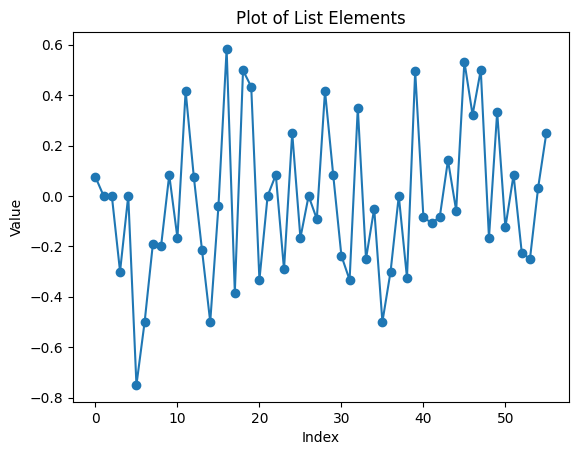

In [5]:
import matplotlib.pyplot as plt
idx = 0
l = [x-y for x,y in zip(llm_score, human_score)]
for el in l:
    if el < 0.1:
        idx+=1

print(idx)
plt.plot(l, marker='o', linestyle='-')
print(np.array(l).mean())
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of List Elements')

# Show the plot
plt.show()